### building a dask array without knowing sizes


#### from dask.dataframe

In [1]:
from dask import array as da, dataframe as ddf, delayed, compute
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
da.from_delayed

<function dask.array.core.from_delayed(value, shape, dtype=None, meta=None, name=None)>

In [3]:
def get_chunk_df(array_size,n_cols):
    col_names = [f"col_{i}" for i in range(n_cols)]
    pd_df = pd.DataFrame(
                {nm:pd.Series(np.arange(array_size[0])) for ic,nm in enumerate(col_names)}
            )
    return pd_df

def get_meta(n_cols):
    col_names = [f"col_{i}" for i in range(n_cols)]
    return {nm:pd.Series([], dtype=np.float64) for nm in col_names}

n_cols = 5
meta_dict = get_meta(n_cols)

In [4]:
delayed_chunks = [delayed(get_chunk_df)((10000+10*ch,),n_cols) for ch in range(0,5)]

In [5]:
df_delayed = ddf.from_delayed(delayed_chunks,meta=meta_dict)

In [6]:
df_delayed

,col_0,col_1,col_2,col_3,col_4
npartitions=5,,,,,
,float64,float64,float64,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [7]:
df = df_delayed.compute()

In [8]:
df.head()

,col_0,col_1,col_2,col_3,col_4
0,0,0,0,0,0
1,1,1,1,1,1
2,2,2,2,2,2
3,3,3,3,3,3
4,4,4,4,4,4


In [9]:
df.size

250500

In [10]:
type(df)

pandas.core.frame.DataFrame

In [11]:
col0 = df_delayed['col_0'].to_dask_array()

In [12]:
col0

dask.array<values, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray>

In [13]:
col0.min()

dask.array<amin-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [14]:
col0.max().compute()

10039

In [15]:
col0.max().compute()

10039

In [16]:
col0np = col0.compute()


In [17]:
col0np.shape

(50100,)

In [18]:
col0np.max()

10039

### direct from_array?

In [19]:
delayed_arrays=[]
for ichunk in range(0,5):
    ra_size = 10000+10*ichunk
    delayed_array = delayed(np.arange)(ra_size)
    delayed_arrays.append(da.from_delayed(delayed_array, (ra_size,), dtype=float))        

In [20]:
delayed_arrays

[dask.array<from-value, shape=(10000,), dtype=float64, chunksize=(10000,), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(10010,), dtype=float64, chunksize=(10010,), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(10020,), dtype=float64, chunksize=(10020,), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(10030,), dtype=float64, chunksize=(10030,), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(10040,), dtype=float64, chunksize=(10040,), chunktype=numpy.ndarray>]

In [21]:
hda = da.hstack(delayed_arrays)

In [22]:
hda

dask.array<concatenate, shape=(50100,), dtype=float64, chunksize=(10040,), chunktype=numpy.ndarray>

In [44]:
def get_delayed_array(base_chunk_size,n_chunks):
    delayed_arrays = []
    for ichunk in range(0,n_chunks):
        ra_size = base_chunk_size+10*ichunk
        delayed_array = delayed(np.arange)(ra_size)
        delayed_arrays.append(da.from_delayed(delayed_array, (ra_size,), dtype=float))        
    return da.hstack(delayed_arrays)

def get_delayed_array_from_df(base_chunk_size,n_chunks):    
    meta_dict = get_meta(1)
    delayed_chunks = [delayed(get_chunk_df)((base_chunk_size+10*ch,),1) for ch in range(0,n_chunks)]
    df_delayed = ddf.from_delayed(delayed_chunks,meta=meta_dict)
    return df_delayed[list(meta_dict.keys())[0]].to_dask_array()

In [45]:
n_chunks = 5
base_chunk_size = 1000

In [46]:
array_from_hstack = get_delayed_array(base_chunk_size,n_chunks)
array_from_df = get_delayed_array_from_df(base_chunk_size,n_chunks)

In [47]:
array_from_hstack

dask.array<concatenate, shape=(5100,), dtype=float64, chunksize=(1040,), chunktype=numpy.ndarray>

In [48]:
array_from_df

dask.array<values, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray>

In [49]:
h_array = array_from_hstack.compute()


In [50]:
df_array = array_from_df.compute()

In [51]:
h_array.shape

(5100,)

In [52]:
df_array.shape

(5100,)

In [53]:
np.all(h_array==df_array)

True

### comparison

In [54]:
def array_construct_compute(base_chunk_size,n_chunks,find_mean=False):
    res1 = get_delayed_array(base_chunk_size,n_chunks)
    if find_mean:
        r = res1.mean().compute()
    else:
        r = res1.compute()
    return

def df_construct_compute(base_chunk_size,n_chunks,find_mean=False):
    res1 = get_delayed_array_from_df(base_chunk_size,n_chunks)
    if find_mean:
        r = res1.mean().compute()
    else:
        r = res1.compute()
    return

In [55]:
base_chunk_size = 100000
test_chunks = np.arange(2,100,5)
results = pd.DataFrame()
for n_chunks in test_chunks:    
    time_result_ar = %timeit -n10 -r5 -o array_construct_compute(base_chunk_size,n_chunks)
    time_result_df = %timeit -n10 -r5 -o df_construct_compute(base_chunk_size,n_chunks)        
    new_row = {
               'chunks':n_chunks,'base_size':base_chunk_size,"actual_size":n_chunks * (base_chunk_size + 10),
               'direct_mean':time_result_ar.average,'direct_std':time_result_ar.stdev,
               'indirect_mean':time_result_df.average,'indirect_std':time_result_df.stdev,
              }
    results = results.append([new_row],ignore_index=True)
    

1.27 ms ± 74.6 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
8.23 ms ± 3.34 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
5.61 ms ± 579 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
36.4 ms ± 9.83 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
11.7 ms ± 3.63 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
88.6 ms ± 4.93 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
14 ms ± 1.33 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
106 ms ± 15.5 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
7.74 ms ± 174 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
88.7 ms ± 39.8 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
9.51 ms ± 457 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
162 ms ± 10.8 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
11.4 ms ± 764 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
190 ms ± 3.43 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
14.4 ms ± 3.84 

In [56]:
results.head()

,chunks,base_size,actual_size,direct_mean,direct_std,indirect_mean,indirect_std
0,2,100000,200020,0.001270,0.000075,0.008228,0.003338
1,7,100000,700070,0.005607,0.000579,0.036371,0.009832
2,12,100000,1200120,0.011663,0.003633,0.088647,0.004935
3,17,100000,1700170,0.013993,0.001325,0.105965,0.015543
4,22,100000,2200220,0.007735,0.000174,0.088736,0.039789


In [66]:
def plot_results(results,xvar='chunks',log_x=False,log_y=True):
    fig = plt.figure()
    clrs = [[0,0,0,1],[1,0,0,1]]  
    plt.subplot(2,1,1)
    xvals = results[xvar]
    for fld,clr in zip(['direct','indirect'],clrs):                
        plt.plot(xvals,results[fld+'_mean'],color=clr,marker='.')
        clr[3] = 0.5        
        for pm in [1,-1]:
            std_pm = results[fld+'_mean'] + results[fld+'_std']* pm *2           
            plt.plot(xvals,std_pm,color=clr)
        if log_y:
            plt.yscale('log')
        if log_x:
            plt.xscale('log')
                    
    plt.ylabel('time [s]')
    
    plt.subplot(2,1,2)
    plt.plot(xvals,results.indirect_mean/results.direct_mean,color='k',marker='.')
    plt.ylabel('indirect / direct ')
    plt.xlabel(xvar)
    if log_x:
            plt.xscale('log')
    return fig


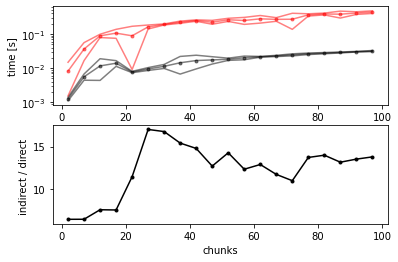

In [67]:

fig = plot_results(results)

In [59]:
base_chunk_size = 100000
test_chunks = np.arange(2,100,5)
results_wmn = pd.DataFrame()
for n_chunks in test_chunks:    
    time_result_ar = %timeit -n10 -r5 -o array_construct_compute(base_chunk_size,n_chunks,True)
    time_result_df = %timeit -n10 -r5 -o df_construct_compute(base_chunk_size,n_chunks, True)        
    new_row = {
               'chunks':n_chunks,'base_size':base_chunk_size,"actual_size":n_chunks * (base_chunk_size + 10),
               'direct_mean':time_result_ar.average,'direct_std':time_result_ar.stdev,
               'indirect_mean':time_result_df.average,'indirect_std':time_result_df.stdev,
              }
    results_wmn = results.append([new_row],ignore_index=True)

2.64 ms ± 560 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
7.94 ms ± 1.76 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
6.87 ms ± 3.09 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
40.9 ms ± 12.5 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
11.5 ms ± 3.63 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
78.4 ms ± 13.8 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
20.6 ms ± 3.45 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
95.6 ms ± 19.2 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
14.7 ms ± 987 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
113 ms ± 29.1 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
12.9 ms ± 935 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
149 ms ± 21.9 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
15.7 ms ± 3.6 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
142 ms ± 32.6 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
15.9 ms ± 602

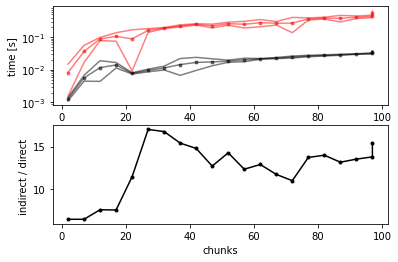

In [68]:
fig = plot_results(results_wmn)

In [61]:
test_sizes = np.logspace(3,6,9-3+1)
n_chunks = 10
results_by_size = pd.DataFrame()
for base_chunk_size in test_sizes:    
    time_result_ar = %timeit -n10 -r5 -o array_construct_compute(base_chunk_size,n_chunks,True)
    time_result_df = %timeit -n10 -r5 -o df_construct_compute(base_chunk_size,n_chunks,True)
    new_row = {
               'chunks':n_chunks,'base_size':base_chunk_size,"actual_size":n_chunks * (base_chunk_size + 10),
               'direct_mean':time_result_ar.average,'direct_std':time_result_ar.stdev,
               'indirect_mean':time_result_df.average,'indirect_std':time_result_df.stdev,
              }
    results_by_size = results_by_size.append([new_row],ignore_index=True)
        

6.41 ms ± 1.97 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
24.7 ms ± 3.7 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
9.9 ms ± 3.92 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
26.8 ms ± 4.61 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
12.5 ms ± 3.55 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
40.8 ms ± 7.36 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
17 ms ± 2.43 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
76.8 ms ± 3.5 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
14.6 ms ± 5.19 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
77.5 ms ± 6.73 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
11.3 ms ± 3.36 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
71.3 ms ± 7.27 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
12 ms ± 972 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
29.2 ms ± 280 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [62]:
results_by_size

,chunks,base_size,actual_size,direct_mean,direct_std,indirect_mean,indirect_std
0,10,1000.000000,1.010000e+04,0.006412,0.001974,0.024670,0.003697
1,10,3162.277660,3.172278e+04,0.009905,0.003915,0.026775,0.004613
2,10,10000.000000,1.001000e+05,0.012499,0.003549,0.040845,0.007361
3,10,31622.776602,3.163278e+05,0.017004,0.002429,0.076810,0.003497
4,10,100000.000000,1.000100e+06,0.014576,0.005195,0.077536,0.006730
5,10,316227.766017,3.162378e+06,0.011283,0.003364,0.071301,0.007267
6,10,1000000.000000,1.000010e+07,0.012025,0.000972,0.029186,0.000280


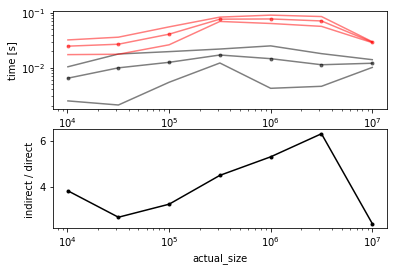

In [69]:
fig = plot_results(results_by_size,xvar='actual_size',log_x=True)

In [64]:
test_sizes = np.logspace(3,6,9-3+1)
n_chunks = 10
results_by_size_nomn = pd.DataFrame()
for base_chunk_size in test_sizes:    
    time_result_ar = %timeit -n10 -r5 -o array_construct_compute(base_chunk_size,n_chunks)
    time_result_df = %timeit -n10 -r5 -o df_construct_compute(base_chunk_size,n_chunks)
    new_row = {
               'chunks':n_chunks,'base_size':base_chunk_size,"actual_size":n_chunks * (base_chunk_size + 10),
               'direct_mean':time_result_ar.average,'direct_std':time_result_ar.stdev,
               'indirect_mean':time_result_df.average,'indirect_std':time_result_df.stdev,
              }
    results_by_size_nomn = results_by_size.append([new_row],ignore_index=True)

2.84 ms ± 107 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
21.8 ms ± 5.04 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
4.18 ms ± 1.11 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
22.9 ms ± 5.14 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
7.98 ms ± 2.15 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
39.3 ms ± 3.47 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
6.96 ms ± 2.63 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
71.2 ms ± 5.24 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
7.28 ms ± 4.1 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
56.6 ms ± 15.9 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
10.1 ms ± 3.85 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
59.2 ms ± 19.5 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
19.6 ms ± 1.44 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
37.9 ms ± 573 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


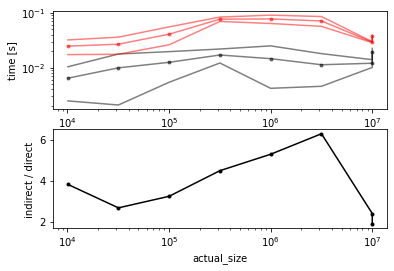

In [70]:
fig = plot_results(results_by_size_nomn,xvar='actual_size',log_x=True)

the question is: 

pre-compute time for counting particles + direct array <= indirect array from dataframe ?